<a href="https://colab.research.google.com/github/linhmai19/dsc-mod-3-project-v2-1-online-ds-sp-000/blob/master/customer_churn_analysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Analysis Project

* Student name: Linh Mai
* Student pace: self paced
* Scheduled project review date/time: July 13th, 2020 
* Instructor name: Jeff Herman
* Blog post URL: https://linhmai19.github.io/ 


In [1]:
from google.colab import files
uploaded = files.upload()

Saving cleaned_customer_churn.csv to cleaned_customer_churn.csv


# Column Description 

Below is the description for each of the columns in the cleaned dataset

* state: the state the user lives in
* account length: the number of days the user has this account
* international plan: true if the user has the international plan, otherwise false
* voice mail plan: true if the user has the voice mail plan, otherwise false
* number vmail messages: the number of voice mail messages the user has sent
* total day minutes: total number of minutes the user has been in calls during the day
* total day calls: total number of calls the user has done during the day
* total day charge: total amount of money the user was charged by the Telecom company for calls during the day
* total eve minutes: total number of minutes the user has been in calls during the evening
* total eve calls: total number of calls the user has done during the evening
* total eve charge: total amount of money the user was charged by the Telecom company for calls during the evening
* total night minutes: total number of minutes the user has been in calls during the night
* total night calls: total number of calls the user has done during the night
* total night charge: total amount of money the user was charged by the Telecom company for calls during the night
* total intl minutes: total number of minutes the user has been in international calls
* total intl calls: total number of international calls the user has done
* total intl charge: total amount of money the user was charged by the Telecom company for international calls
* customer service calls: number of customer service calls the user has done
* churn: true if the user terminated the contract, otherwise false
* total charge: total amount of money the user was charged by the Telecom company overall

# Import libraries

In [2]:
import pandas as pd
import numpy as np 
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import the cleaned dataset and review it

In [3]:
df = pd.read_csv('cleaned_customer_churn.csv')
df = df.drop('Unnamed: 0', 1)
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total charge
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,75.56
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,59.24
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,62.29
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,66.80
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,52.09


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3260 entries, 0 to 3259
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3260 non-null   object 
 1   account length          3260 non-null   int64  
 2   international plan      3260 non-null   object 
 3   voice mail plan         3260 non-null   object 
 4   number vmail messages   3260 non-null   int64  
 5   total day minutes       3260 non-null   float64
 6   total day calls         3260 non-null   int64  
 7   total day charge        3260 non-null   float64
 8   total eve minutes       3260 non-null   float64
 9   total eve calls         3260 non-null   int64  
 10  total eve charge        3260 non-null   float64
 11  total night minutes     3260 non-null   float64
 12  total night calls       3260 non-null   int64  
 13  total night charge      3260 non-null   float64
 14  total intl minutes      3260 non-null   

## Visualize the distribution of the target variable

False    2791
True      469
Name: churn, dtype: int64


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

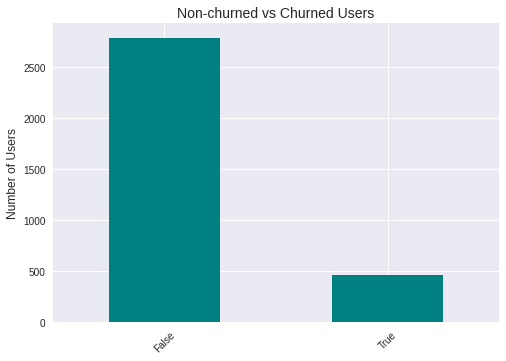

In [5]:
print(df.churn.value_counts())
df['churn'].value_counts().plot(kind='bar', color='teal')
plt.title('Non-churned vs Churned Users', fontsize=14)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45)

##### The amount of non-churned customers are much more than the number of churned customers which created the imbalance in the target varivable. Therefore, in order to biased towards the majority in predictive models later, I need to take into consideration about the use of oversampling when building the models. 

# Visualize the categorical features

In [6]:
# Categorical features
cat_feats = ['state', 'international plan', 'voice mail plan']

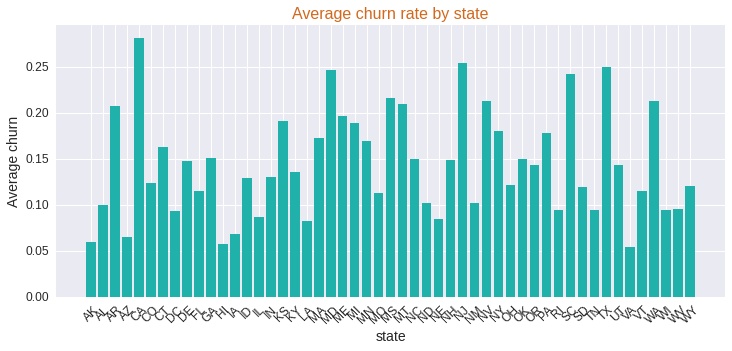

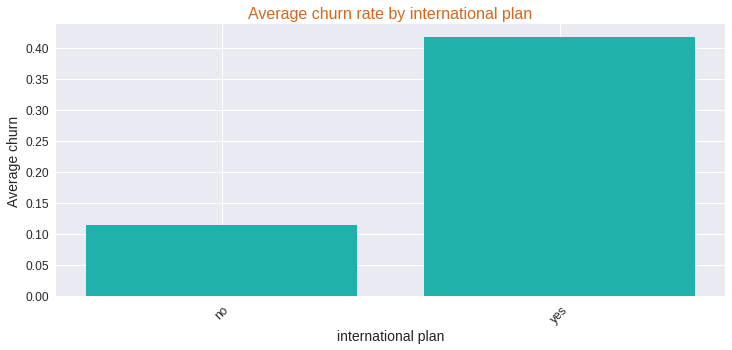

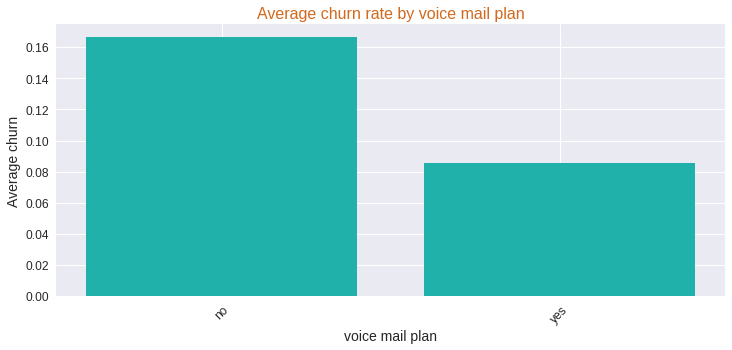

In [7]:
def visualize_influence(feature_list):
    for feature in feature_list:
        df_plot = df.groupby([feature])['churn'].mean().reset_index()
        x = df_plot[feature]
        y = df_plot['churn']
        plt.figure(figsize=(12, 5))
        plt.bar(x, y, color='lightseagreen')
        plt.xlabel(feature, fontsize=14)
        plt.ylabel('Average churn', fontsize=14)
        plt.title(f'Average churn rate by {feature}', fontsize=16, color='chocolate')
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.show();
        
visualize_influence(cat_feats)

#### General comments on the visualization 
* The states with high amount of churned customers are CA, MD, NU, SC, and TX
* The states with low amount of churned customers are AK, AZ, HI, and VA
* Customers with the international plan have higher proportion of churn than the customers without
* Nothing special to comment more on the plot for churn rate by voice mail plan

# Visualize the continuous features

In [8]:
# Continuous features
con_feats = ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 
             'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge',
             'total night minutes', 'total night calls', 'total night charge', 'total intl minutes',
             'total intl calls', 'total intl charge', 'customer service calls', 'total charge']

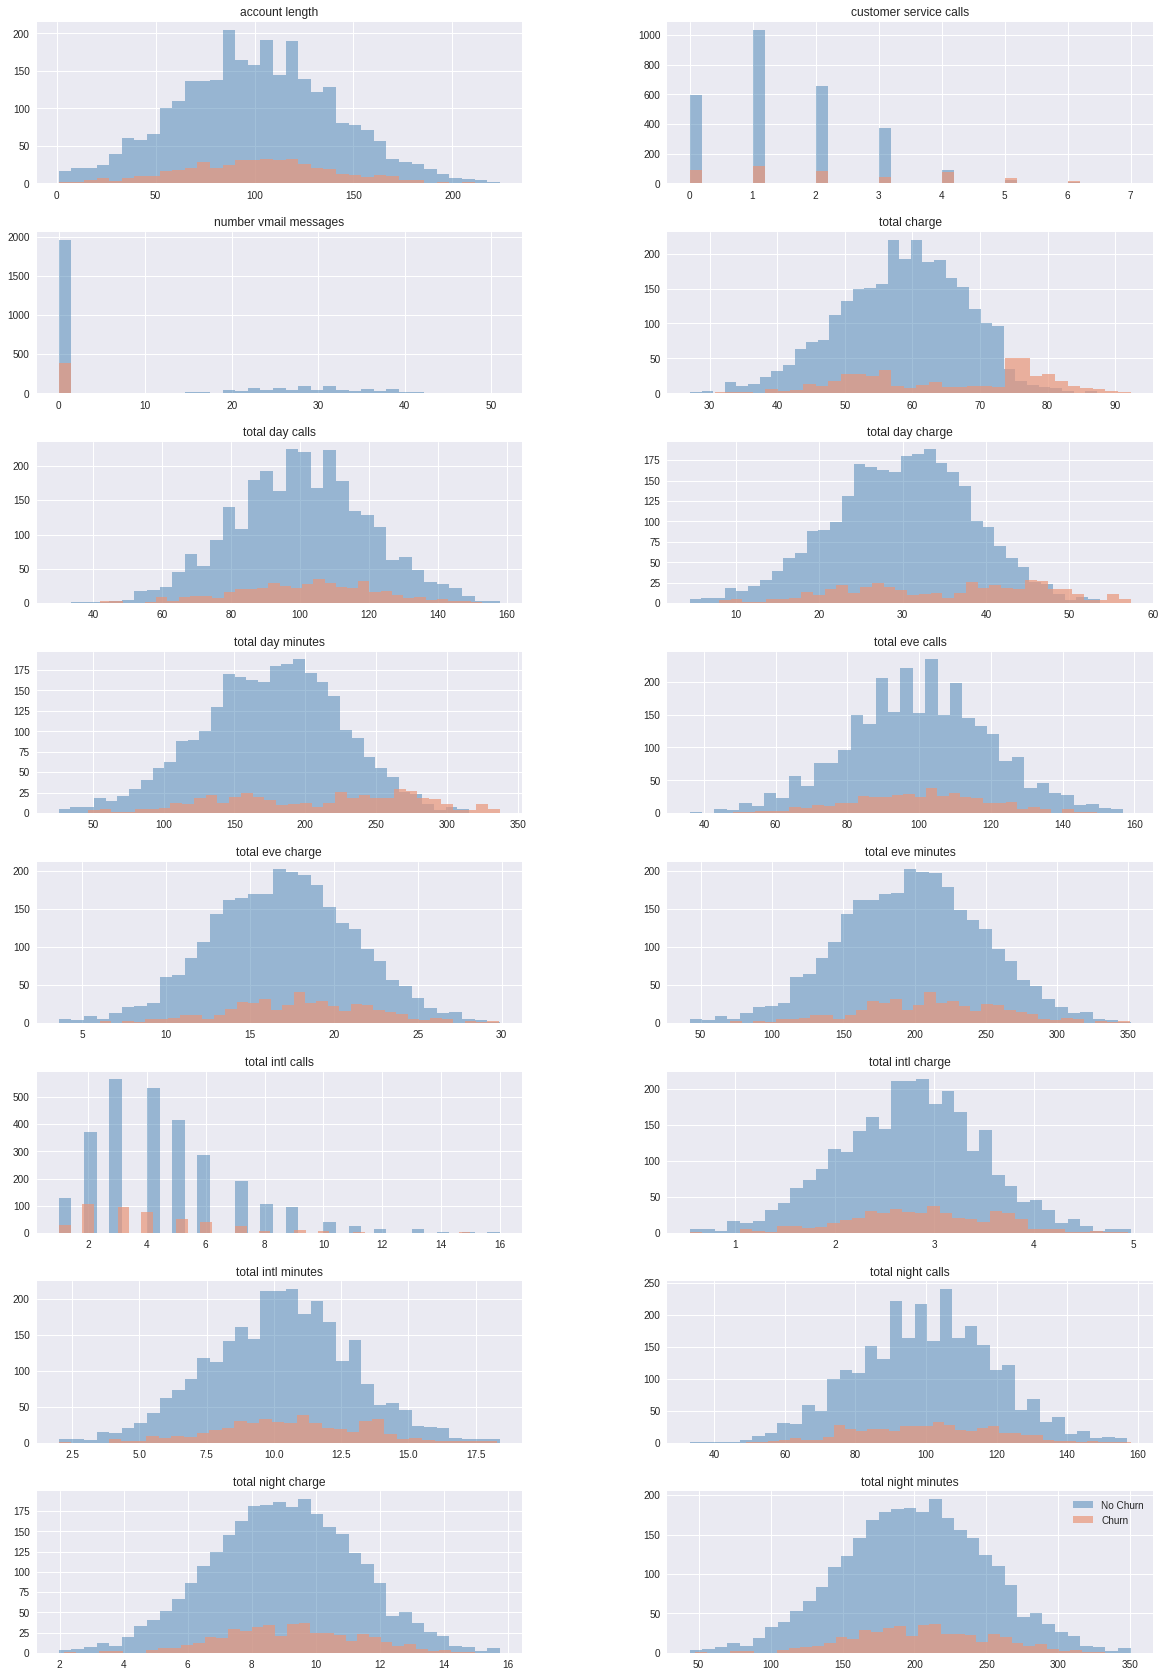

In [9]:
fig, ax = plt.subplots(8, 2, figsize=(20, 30))
df[df.churn == False][con_feats].hist(bins=35, color="steelblue", alpha=0.5, ax=ax)
df[df.churn == True][con_feats].hist(bins=35, color="darksalmon", alpha=0.7, ax=ax)
plt.legend(['No Churn', 'Churn'])

#### General comments on the visualization 
* 'customer service calls' is positively skewed. 
* In the'total intl calls' histogram, both churned and non-churned users are having a similar number of international calls
* In the histograms for 'total day minutes', 'total_day_charge', and 'total charge', the customer with higher values in these features are more likely to churn 
* In the 'total intl minutes' histogram, churned customers tend to have longer international calls (longer in minutes) than non-churned customers
* In the 'number vmail messages' histogram, the users who did not churn tends to have more voice mail messages

# Deal with categorical features

In [10]:
# LabelEncoding the categorical features into numeric values
label_encode = LabelEncoder()

df['state'] = label_encode.fit_transform(df['state'])
df['international plan'] = label_encode.fit_transform(df['international plan'])
df['voice mail plan'] = label_encode.fit_transform(df['voice mail plan'])

In [11]:
# Check the data types in columns and some general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3260 entries, 0 to 3259
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3260 non-null   int64  
 1   account length          3260 non-null   int64  
 2   international plan      3260 non-null   int64  
 3   voice mail plan         3260 non-null   int64  
 4   number vmail messages   3260 non-null   int64  
 5   total day minutes       3260 non-null   float64
 6   total day calls         3260 non-null   int64  
 7   total day charge        3260 non-null   float64
 8   total eve minutes       3260 non-null   float64
 9   total eve calls         3260 non-null   int64  
 10  total eve charge        3260 non-null   float64
 11  total night minutes     3260 non-null   float64
 12  total night calls       3260 non-null   int64  
 13  total night charge      3260 non-null   float64
 14  total intl minutes      3260 non-null   

In [12]:
# Check the dataset again
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total charge
0,16,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,75.56
1,35,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,59.24
2,31,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,62.29
3,35,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,66.80
4,36,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,52.09


# Explore the relationships between variables

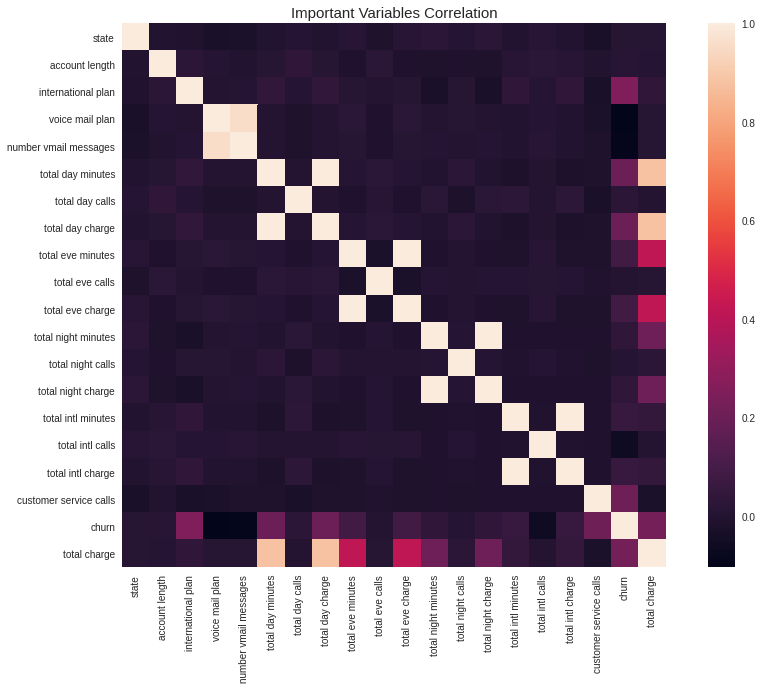

In [13]:
corr = df.corr(method='pearson')
f, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr, vmax=1., square=True)
plt.title("Important Variables Correlation", fontsize=15)
plt.show()

#### General comments on the correlation between features and target
* High correlation between 'voice mail plan' and 'number vmail messages' --> makes sense because customers with a voice mail plan send more voice mail messages
* Greatly high correlation between 'total day minutes' and 'total day charge'. I also found the same patterns for other pairs: 'total eve minutes' and 'total eve charge', 'total night minutes' and 'total night charge', and 'total intl minutes' and 'total intl charge' --> the telecom company seems to charge customers by minutes of calls
* There are also a slightly lower correlations between 'total charge' with 'total day minutes', and with 'total day charge'

In [14]:
# Calculate correlation of each feature to price and sort in descending order

corr = df.corr()
corr = corr.stack().reset_index()
corr = corr.rename(columns = {'level_0':'Target', 'level_1':'Features', 0:'Correlation_Values'})
corr = corr.loc[corr['Target'] == 'churn']
corr.sort_values(by = 'Correlation_Values', ascending = False)

,Target,Features,Correlation_Values
378,churn,churn,1.000000
362,churn,international plan,0.254268
379,churn,total charge,0.227134
377,churn,customer service calls,0.204508
365,churn,total day minutes,0.201917
367,churn,total day charge,0.201917
368,churn,total eve minutes,0.089451
370,churn,total eve charge,0.089440
376,churn,total intl charge,0.057910
374,churn,total intl minutes,0.057888


# Standardize features and Train Test Split

In [15]:
# Create features X and target y
y = df['churn']
X = df.drop('churn', axis=1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data 
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

# Build the Baseline Model with Logistic Regression


In [16]:
# Fit a model
logreg = LogisticRegression(fit_intercept=False, C=1e15, solver='liblinear')
base_model_log = logreg.fit(X_train_scaled, y_train)
# Preview model params
print(base_model_log)

LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


#### Mean Cross Validation Score for the baseline model

In [17]:
# Mean cross validation score of the baseline model
mean_logreg_score = np.mean(cross_val_score(logreg, X_train, y_train, cv=3))
print(f'Mean Cross Validation Score: {mean_logreg_score: .2%}')

Mean Cross Validation Score:  85.77%


#### Classification Report for the baseline model

In [18]:
# Model prediction
logreg_train_pred = logreg.predict(X_train_scaled)
logreg_test_pred = logreg.predict(X_test_scaled)
test_pred = base_model_log.predict(X_test_scaled)

# Classification report for the baseline model
base_model_report = classification_report(y_test, test_pred)
print('Baseline Model Classification Report')
print('------------------------------------')
print(base_model_report)

Baseline Model Classification Report
------------------------------------
              precision    recall  f1-score   support

       False       0.96      0.65      0.77       555
        True       0.30      0.86      0.44        97

    accuracy                           0.68       652
   macro avg       0.63      0.75      0.61       652
weighted avg       0.86      0.68      0.72       652



#### Confusion matrix for the baseline model

In [19]:
cnf_matrix = confusion_matrix(y_test, logreg_test_pred)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[358 197]
 [ 14  83]]


In [20]:
# Add appropriate axis scales
# Get class labels to add to matrix
class_names = set(y) 

In [21]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, cmap=cmap)
    
    # Add title and axis labels 
    plt.title('Confusion Matrix') 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    # Add appropriate axis scales
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = cm.max() / 2.
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Add a legend
    plt.colorbar()
    plt.show() 

Confusion matrix, without normalization


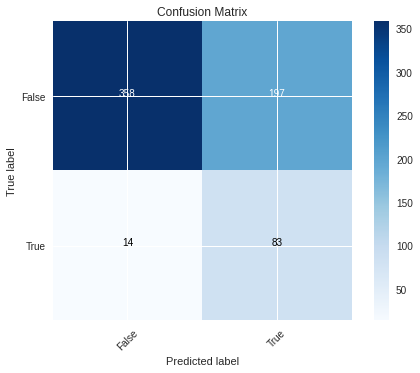

In [22]:
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False)

#### ROC Curve for Baseline model

To show the True Positive rate against the False Positive rate for the baseline model

In [23]:
# Calculate the probability scores for each point 
y_score = base_model_log.decision_function(X_test_scaled)
# Calculate the fpr, tpr, and thresholds
fpr, tpr, threshold = roc_curve(y_test, y_score)

AUC: 0.8286802266183709



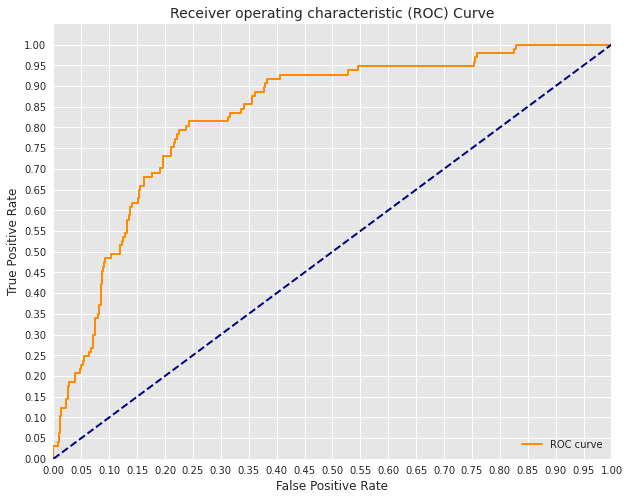

In [24]:
# Plot the ROC curve
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(fpr, tpr)))
print('')
plt.show()

# Deal with Class Imbalance 

In [25]:
df['churn'].value_counts(normalize=True)

False    0.856135
True     0.143865
Name: churn, dtype: float64

As mentioned earlier, the amount of non-churned customers are much more than the number of churned customers which created the class imbalance problem. Although the baseline model is 86.38% accurately identifying whether a customer will churn from SyriaTel, in fact, more than 85% of the data is non-churned users. In other words, there are more negative observations (non-churned users), so it is easy for the model to predict the negatives cases correctly. Therefore, to better train the models, I need to perform Synhetic Minority Oversampling or SMOTE. 

It is an algorithm to generate new sample data by creating synthetic examples that are combinations of the closest minority class cases. 

SMOTE algorithm applies K Nearest Neighbors approach where it selects one of the KNN and computes the vector between the original point and the selected neighbor. The difference is multiplied by random number between (0, 1) and it is added back to original point to obtain the new synthetic point. Geometrically, the synthetic point is somewhere on the line between the original point and its neighbor.

In [26]:
print("Before OverSampling, counts of label 'True': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label 'False': {} \n".format(sum(y_train == 0)))

# Perform SMOTE
smote = SMOTE(random_state=42)
# Resample the dataset
X_train_smote, y_train_smote = smote.fit_sample(X_train_scaled, y_train)

# Fit the model again after SMOTE
smote_logreg = LogisticRegression(fit_intercept=False, C=1e15, solver='liblinear')
smote_model_log = smote_logreg.fit(X_train_smote, y_train_smote)

print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape)) 
  
print("After OverSampling, counts of label 'True': {}".format(sum(y_train_smote == 1))) 
print("After OverSampling, counts of label 'False': {}".format(sum(y_train_smote == 0))) 

Before OverSampling, counts of label 'True': 372
Before OverSampling, counts of label 'False': 2236 

After OverSampling, the shape of train_X: (4472, 19)
After OverSampling, the shape of train_y: (4472,) 

After OverSampling, counts of label 'True': 2236
After OverSampling, counts of label 'False': 2236


The SMOTE algorithm has oversampled the minority instances (churned customers) and made it equal to the majority classes (non-churned customers). 

In [27]:
# Model prediction
smote_test_pred = smote_logreg.predict(X_test_scaled)
smote_train_pred = smote_logreg.predict(X_train_smote)
smote_pred = smote_model_log.predict(X_test_scaled)

smote_model_report = classification_report(y_test, smote_pred)
# Classification report for the baseline model
print('Baseline Model Classification Report')
print('------------------------------------')
print(base_model_report)
print('Classification Report after SMOTE')
print('------------------------------------')
print(smote_model_report)

Baseline Model Classification Report
------------------------------------
              precision    recall  f1-score   support

       False       0.96      0.65      0.77       555
        True       0.30      0.86      0.44        97

    accuracy                           0.68       652
   macro avg       0.63      0.75      0.61       652
weighted avg       0.86      0.68      0.72       652

Classification Report after SMOTE
------------------------------------
              precision    recall  f1-score   support

       False       0.97      0.62      0.75       555
        True       0.29      0.90      0.44        97

    accuracy                           0.66       652
   macro avg       0.63      0.76      0.60       652
weighted avg       0.87      0.66      0.71       652



The accuracy was reduced from 64% to 62% and the recall value of minority class (churned users) was improved from 89% to 90%

#### Confusion matrix after SMOTE

In [28]:
smote_cnf_matrix = confusion_matrix(y_test, smote_test_pred)
print('Confusion Matrix of Baseline model: \n', cnf_matrix)
print('Confusion Matrix after SMOTE: \n', smote_cnf_matrix)

Confusion Matrix of Baseline model: 
 [[358 197]
 [ 14  83]]
Confusion Matrix after SMOTE: 
 [[342 213]
 [ 10  87]]


Confusion matrix, without normalization


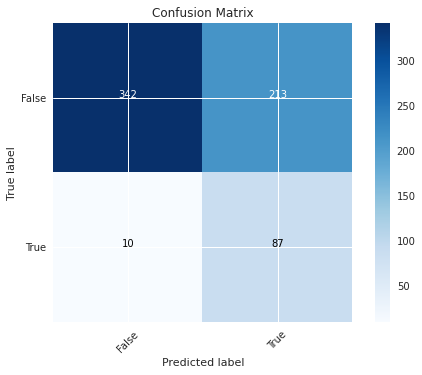

In [29]:
plot_confusion_matrix(smote_cnf_matrix, classes=class_names, normalize=False)

#### ROC Curve after SMOTE

AUC after SMOTE: 0.8395281879817963



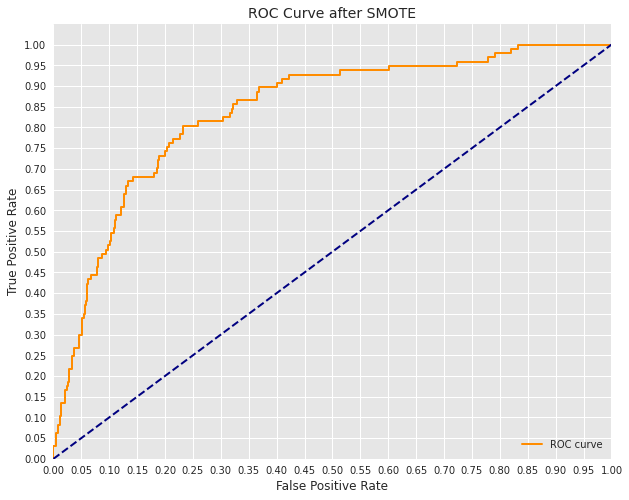

In [30]:
# Calculate the probability scores for each point 
smote_y_score = smote_model_log.decision_function(X_test_scaled)
# Calculate the fpr, tpr, and thresholds
smote_fpr, smote_tpr, threshold = roc_curve(y_test, smote_y_score)

# Plot the ROC curve
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(smote_fpr, smote_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve after SMOTE', fontsize=14)
plt.legend(loc='lower right')
print('AUC after SMOTE: {}'.format(auc(smote_fpr, smote_tpr)))
print('')
plt.show()

After SMOTE, the model performance was improved by about 1.29%. 
Not much in term of improvement

# Feature Selection 

In [31]:
X = sm.add_constant(X)  # need to add this to define the Intercept
# model / fit / summarize results
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  churn   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     38.59
Date:                Mon, 06 Jul 2020   Prob (F-statistic):          2.56e-122
Time:                        21:38:36   Log-Likelihood:                -895.67
No. Observations:                3260   AIC:                             1829.
Df Residuals:                    3241   BIC:                             1945.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.4780      0.069     -6.966      0.000      -0.612      -0.343
state                      0.0003      0.000      0.780      0.436      -0.000       0.001
account length          8.987e-05      0.000      0.636      0.525      -0.000       0.000
international plan         0.2987      0.019     15.702      0.000       0.261       0.336
voice mail plan           -0.1392      0.043     -3.216      0.001      -0.224      -0.054
number vmail messages      0.0021      0.001      1.467      0.142      -0.001       0.005
total day minutes          0.0871      0.333      0.262      0.794      -0.565       0.740
total day calls            0.0004      0.000      1.406      0.160      -0.000       0.001
total day charge          -0.6084      1.697     -0.359      0.720      -3.935       2.718
total eve minutes          0.1164      0.165      0.705      0.481      -0.207       0.440
total eve calls        -1.263e-05      0.000     -0.044      0.965      -0.001       0.001
total eve charge          -1.4654      1.701     -0.862      0.389      -4.800       1.869
total night minutes       -0.0414      0.089     -0.468      0.640      -0.215       0.132
total night calls          0.0001      0.000      0.370      0.711      -0.000       0.001
total night charge         0.8239      1.703      0.484      0.628      -2.514       4.162
total intl minutes        -0.3863      0.525     -0.735      0.462      -1.417       0.644
total intl calls          -0.0094      0.002     -3.967      0.000      -0.014      -0.005
total intl charge          1.3535      1.693      0.800      0.424      -1.965       4.672
customer service calls     0.0583      0.004     13.472      0.000       0.050       0.067
total charge               0.1036      0.788      0.131      0.895      -1.442       1.649
==============================================================================
Omnibus:                      807.338   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1589.775
Skew:                           1.506   Prob(JB):                         0.00
Kurtosis:                       4.623   Cond. No.                     2.85e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.45e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Top features by XGBoost

XGBoost Accuracy on Training Set:  0.9808282208588958
XGBoost Accuracy on Testing Set:  0.9785276073619632


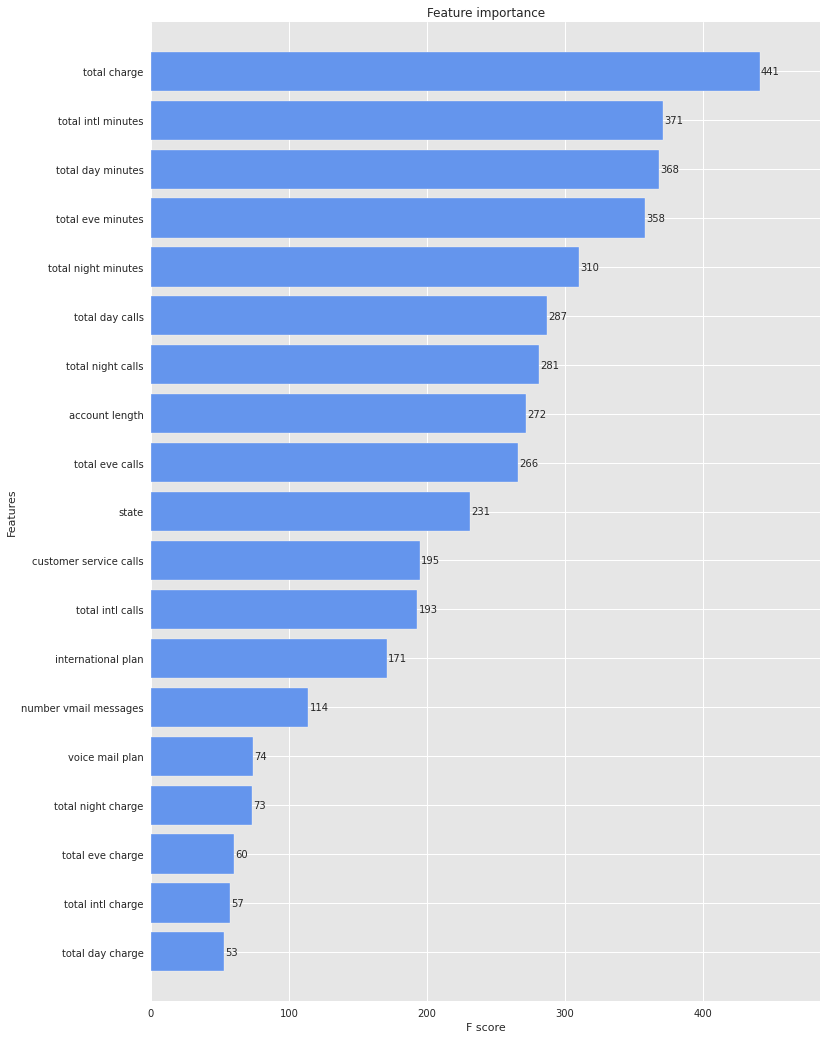

In [41]:
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective='binary:logistic')
xgb_model.fit(X_train, y_train)
xgb_test_pred = xgb_model.predict(X_test)

# Accuracy scores on training and test sets
print('XGBoost Accuracy on Training Set: ', xgb_model.score(X_train, y_train))
print('XGBoost Accuracy on Testing Set: ', xgb_model.score(X_test, y_test))

# plot the important features
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf, max_num_features=50, height=0.8, ax=ax, color='cornflowerblue')
plt.show()

**Comparing Classification reports of: Baseline logistic regression model, SMOTE model, and baseline XGB model**

In [43]:
baseline_xgb_report = classification_report(y_test, xgb_test_pred)

print('Baseline Logistic Regression Classification Report:\n')
print('-----------------------------------------------------')
print(base_model_report)
print('SMOTE model Classification Report:\n')
print('-----------------------------------------------------')
print(smote_model_report)
print('Baseline XGBoost Classification Report:\n')
print('-----------------------------------------------------')
print(baseline_xgb_report)

Baseline Logistic Regression Classification Report:

-----------------------------------------------------
              precision    recall  f1-score   support

       False       0.96      0.65      0.77       555
        True       0.30      0.86      0.44        97

    accuracy                           0.68       652
   macro avg       0.63      0.75      0.61       652
weighted avg       0.86      0.68      0.72       652

SMOTE model Classification Report:

-----------------------------------------------------
              precision    recall  f1-score   support

       False       0.97      0.62      0.75       555
        True       0.29      0.90      0.44        97

    accuracy                           0.66       652
   macro avg       0.63      0.76      0.60       652
weighted avg       0.87      0.66      0.71       652

Baseline XGBoost Classification Report:

-----------------------------------------------------
              precision    recall  f1-score   support


# Build Models

### 1) LogisticRegression

In [ ]:
X = 